In [1]:
import copy
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

In [2]:
# used code for truncating from https://www.delftstack.com/howto/python/python-truncate-float-python/
def truncate(number, decimal):
 integer = int(number * (10 ** decimal)) / (10 ** decimal)
 return float(integer)

In [3]:
def init():
    print("Welcome to my Feature Selection Algorithm.")
    fileName = input("Type in the name of the file to test: ")
    algoNum = int(input("Type in the number of the algorithm you want to run:\n1) Forward Selection\n2) Backward Elimination\n"))
    
    # https://www.geeksforgeeks.org/python-read-csv-using-pandas-read_csv/
    return (pd.read_csv(fileName, delim_whitespace=True, header=None).to_numpy(), algoNum)

In [4]:
def forwardGraph(features, accuracies):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title('Forward Selection')
    ax.bar(features, accuracies, tick_label=features)
    ax.set_xlabel('Features')
    plt.xticks(rotation="vertical")
    ax.set_ylabel('Accuracies (decimal)')
def backwardGraph(features, accuracies):
#     featuresLarge = ['AF*', '193', '24', '209', '135', '17', '153', '68', '40', '33', '98']
#     accuraciesLarge = [71.22, 72.11, 72.77, 73.66, 74.55, 74.77, 75.66, 75.88, 76.11, 76.11, 76.66]
#     features = featuresLarge
#     accuracies = accuraciesLarge

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title('Backward Selection')
    ax.bar(features, accuracies, tick_label=features)
    ax.set_xlabel('Features')
#     ax.set_xlabel('Features Deleted')
    plt.xticks(rotation="vertical")
#     plt.xticks(rotation="vertical")
    ax.set_ylabel('Accuracies (decimal)')


    

In [5]:
# need to convert to string so that we can use them for graph (can't use ints for graph axis labeling)
# https://www.geeksforgeeks.org/python-convert-list-of-lists-to-list-of-strings/
def convert(features):
    features = [', '.join(map(str, ele)) for ele in features]
    return features

In [6]:
def leaveOneOutCrossValidation(rows):
    numberCorrectlyClassified = 0
    
    for i in range(len(rows)):
        objectToClassify = rows[i, 1:]
        labelObjectToClassify = rows[i, 0]
        nearestNeighborDistance = float("inf")
        nearestNeighborLocation = float("inf")
        
        for j in range(len(rows)):
            if (j != i):
                distance = np.sqrt(np.sum(np.square(objectToClassify - rows[j, 1:])))
                if (distance < nearestNeighborDistance):
                    nearestNeighborDistance = distance
                    nearestNeighborLocation = j
                    nearestNeighborLabel = rows[nearestNeighborLocation, 0]
                    
        if (labelObjectToClassify == nearestNeighborLabel):
            numberCorrectlyClassified += 1
        
    accuracy = numberCorrectlyClassified / len(rows)
    
    return accuracy

In [7]:
def forwardFeatureSearch(rows):
    print("Beginning search.")
    start = time.time()
    
    features = []
    accuracies = []
    currentSetOfFeatures = [0]   # "empty" set
    bestAccuracy = 0
    
    # empty set accuracy
    currentSetAdded1 = copy.deepcopy(currentSetOfFeatures)
    rowsAdded2 = rows[:, currentSetAdded1]
    accuracy2 = leaveOneOutCrossValidation(rowsAdded2)
    currentSetAdded2 = copy.deepcopy(currentSetAdded1)
    currentSetAdded2.pop(0)   # remove class label
    print("Initial accuracy: " + str(truncate(accuracy2 * 100, 2)) + "% with current set " + str(currentSetAdded2))
    features.append(currentSetAdded1)
    accuracies.append(accuracy2)
    
    for i in range(1, len(rows[0])):
        print("On the " + str(i) + "th level of the search tree")
        currentSet = copy.deepcopy(currentSetOfFeatures)
        featureToAdd = []
        bestSoFarAccuracy = 0
        
        for j in range(1, len(rows[0])):
            if (j not in currentSetOfFeatures):
                currentSet.append(j)
                rowsAdded = rows[:, currentSet]
                
                accuracy = leaveOneOutCrossValidation(rowsAdded)
                print("\tConsidering adding the " + str(j) + " feature")
                selectedCurrentSetAdded = copy.deepcopy(currentSet)
                selectedCurrentSetAdded.pop(0)
                resetSet = copy.deepcopy(currentSetOfFeatures)
                currentSet = resetSet
                print("\tUsing feature(s) " + str(selectedCurrentSetAdded) + " accuracy is " + str(truncate(accuracy * 100, 2)) +"%")
                
                if (accuracy > bestSoFarAccuracy):
                    bestSoFarAccuracy = accuracy
                    featureToAdd = j
                    
        prevCurrentSetOfFeatures = copy.deepcopy(currentSetOfFeatures)
        prevCurrentSetOfFeatures.pop(0)
        currentSetOfFeatures.append(featureToAdd)
        features.append(copy.deepcopy(currentSetOfFeatures))
        accuracies.append(bestSoFarAccuracy)
        
        selectedCurrentSetOfFeatures = copy.deepcopy(currentSetOfFeatures)
        selectedCurrentSetOfFeatures.pop(0)
        
        print("Features set " + str(featureToAdd) + " was best, accuracy is " + str(truncate(bestSoFarAccuracy * 100, 2)) + "%")
        print("On level " + str(i) + ", I added feature " + str(featureToAdd) + " with accuracy " + str(truncate(bestSoFarAccuracy * 100, 2)) + "% to previous set " + str(prevCurrentSetOfFeatures) + " to have current set " + str(selectedCurrentSetOfFeatures))
        
        if (bestAccuracy > bestSoFarAccuracy):
            print("Warning, Accuracy has decreased! Continuing search in case of local maxima")
        elif (bestSoFarAccuracy > bestAccuracy):
            bestAccuracy = bestSoFarAccuracy
    
    end = time.time()
    elapsedTime = str(truncate(end - start, 4))
    
    # find best features
    count = 0
    max2 = 0
    index = 0
    for i in accuracies:
        if i > max2:
            max2 = i
            index = count
        count = count + 1
    
    temp = copy.deepcopy(features)
    bestFeatures = temp[index]
    bestFeatures.pop(0)
    
    print("Finished search in " + str(elapsedTime) + " seconds!! The best feature subset is " + str(bestFeatures) + ", which has an accuracy of " + str(truncate(bestAccuracy * 100, 2)) + "%")
            
    return (features, accuracies, elapsedTime)

In [8]:
def backwardFeatureSearch(rows):
    print("Beginning search.")
    start = time.time()
    
    features = []
    accuracies = []
    currentSetOfFeatures = [0]   # "empty" set
    bestAccuracy = 0
    
    count = 1
    for i in range(1, len(rows[0])):
        currentSetOfFeatures.append(count)
        count += 1
        
    # full set accuracy
    currentSetAdded1 = copy.deepcopy(currentSetOfFeatures)
    rowsAdded2 = rows[:, currentSetAdded1]
    accuracy2 = leaveOneOutCrossValidation(rowsAdded2)
    currentSetAdded2 = copy.deepcopy(currentSetAdded1)
    currentSetAdded2.pop(0)   # remove class label
    print("Initial accuracy: " + str(truncate(accuracy2 * 100, 2)) + "% with current set " + str(currentSetAdded2))
    features.append(currentSetAdded1)
    accuracies.append(accuracy2)
        
    for i in range(1, len(rows[0])):
        print("On the " + str(i) + "th level of the search tree")
        currentSet = copy.deepcopy(currentSetOfFeatures)
        featureToDelete = []
        bestSoFarAccuracy = 0
        
        for j in range(1, len(rows[0])):
            if (j in currentSetOfFeatures):
                currentSet.remove(j)
                rowsDeleted = rows[:, currentSet]
                
                accuracy = leaveOneOutCrossValidation(rowsDeleted)
                print("\tConsidering deleting the " + str(j) + " feature")
                selectedCurrentSetDeleted = copy.deepcopy(currentSet)
                selectedCurrentSetDeleted.pop(0)
                resetSet = copy.deepcopy(currentSetOfFeatures)
                currentSet = resetSet
                print("\tUsing feature(s) " + str(selectedCurrentSetDeleted) + " accuracy is " + str(truncate(accuracy * 100, 2)) +"%")
                
                if accuracy > bestSoFarAccuracy:
                    bestSoFarAccuracy = accuracy
                    featureToDelete = j
                 
        prevCurrentSetOfFeatures = copy.deepcopy(currentSetOfFeatures)
        prevCurrentSetOfFeatures.pop(0)
        currentSetOfFeatures.remove(featureToDelete)
        features.append(copy.deepcopy(currentSetOfFeatures))
        accuracies.append(bestSoFarAccuracy)
        
        selectedCurrentSetOfFeatures = copy.deepcopy(currentSetOfFeatures)
        selectedCurrentSetOfFeatures.pop(0)
        
        print("Features set " + str(featureToDelete) + " was best, accuracy is " + str(truncate(bestSoFarAccuracy * 100, 2)) + "%")
        print("On level " + str(i) + ", I deleted feature " + str(featureToDelete) + " with accuracy " + str(truncate(bestSoFarAccuracy * 100, 2)) + "% from previous set " + str(prevCurrentSetOfFeatures) + " to have current set " + str(selectedCurrentSetOfFeatures))
        
        if (bestAccuracy > bestSoFarAccuracy):
            print("Warning, Accuracy has decreased! Continuing search in case of local maxima")
        elif (bestSoFarAccuracy > bestAccuracy):
            bestAccuracy = bestSoFarAccuracy
            
    end = time.time()
    elapsedTime = str(truncate(end - start, 4))
    
    # find best features
    count = 0
    max2 = 0
    index = 0
    for i in accuracies:
        if i > max2:
            max2 = i
            index = count
        count = count + 1
    temp = copy.deepcopy(features)
    bestFeatures = temp[index]
    bestFeatures.pop(0)

    print("Finished search in " + str(elapsedTime) + " seconds!! The best feature subset is " + str(bestFeatures)  + ", which has an accuracy of " + str(truncate(bestAccuracy * 100, 2)) + "%")
    
    return (features, accuracies, elapsedTime)

In [9]:
def main():
    rows, specifiedFeatureSearch = init()
    
    forwardFeatures = []
    forwardAccuracies = 0
    backwardFeatures = []
    backwardAccuracies = 0
    forwardElapsedTime = 0
    backwardElapsedTime = 0

    
    if (specifiedFeatureSearch == 1):
        forwardFeatures, forwardAccuracies, forwardElapsedTime = forwardFeatureSearch(rows)
    elif (specifiedFeatureSearch == 2):
        backwardFeatures, backwardAccuracies, backwardElapsedTime = backwardFeatureSearch(rows)
        
    print("\n\n\n\n\n")   # separation between forward and backward outputs
        
    # run opposite feature search for graph
    if (specifiedFeatureSearch == 1):
        backwardFeatures, backwardAccuracies, backwardElapsedTime = backwardFeatureSearch(rows)
    elif (specifiedFeatureSearch == 2):
        forwardFeatures, forwardAccuracies, forwardElapsedTime = forwardFeatureSearch(rows)

    print("Forward Elapsed Time: " + str(forwardElapsedTime) + " seconds")
    print("Backward Elapsed Time: " + str(backwardElapsedTime) + " seconds")
    
    return (forwardFeatures, forwardAccuracies, forwardElapsedTime, backwardFeatures, backwardAccuracies, backwardElapsedTime)

In [10]:
forwardFeatures, forwardAccuracies, forwardElapsedTime, backwardFeatures, backwardAccuracies, backwardElapsedTime = main()

Welcome to my Feature Selection Algorithm.
Type in the name of the file to test: small.txt
Type in the number of the algorithm you want to run:
1) Forward Selection
2) Backward Elimination
1
Beginning search.
Initial accuracy: 84.0% with current set []
On the 1th level of the search tree
	Considering adding the 1 feature
	Using feature(s) [1] accuracy is 72.0%
	Considering adding the 2 feature
	Using feature(s) [2] accuracy is 74.66%
	Considering adding the 3 feature
	Using feature(s) [3] accuracy is 77.0%
	Considering adding the 4 feature
	Using feature(s) [4] accuracy is 70.66%
	Considering adding the 5 feature
	Using feature(s) [5] accuracy is 69.66%
	Considering adding the 6 feature
	Using feature(s) [6] accuracy is 77.33%
	Considering adding the 7 feature
	Using feature(s) [7] accuracy is 74.0%
	Considering adding the 8 feature
	Using feature(s) [8] accuracy is 71.66%
	Considering adding the 9 feature
	Using feature(s) [9] accuracy is 86.0%
	Considering adding the 10 feature
	Usin

In [11]:
# remove class labels
forwardFeatures2 = []
temp = copy.deepcopy(forwardFeatures)
for item in temp:
    item.pop(0)
    forwardFeatures2.append(copy.deepcopy(item))
backwardFeatures2 = []
temp2 = copy.deepcopy(backwardFeatures)
for item in temp2:
    item.pop(0)
    backwardFeatures2.append(copy.deepcopy(item))

print(forwardFeatures2)
print(len(forwardFeatures2))
print()
print(forwardAccuracies)
print(len(forwardAccuracies))
print()
print(backwardFeatures2)
print(len(backwardFeatures2))
print()
print(backwardAccuracies)
print(len(backwardAccuracies))
print()

tempForward = copy.deepcopy(forwardFeatures2)
tempBackward = copy.deepcopy(backwardFeatures2)
print(tempForward)
print("\n")
resForward = convert(tempForward)
resBackward = convert(tempBackward)
print(resForward)

[[], [9], [9, 3], [9, 3, 10], [9, 3, 10, 5], [9, 3, 10, 5, 2], [9, 3, 10, 5, 2, 7], [9, 3, 10, 5, 2, 7, 4], [9, 3, 10, 5, 2, 7, 4, 8], [9, 3, 10, 5, 2, 7, 4, 8, 6], [9, 3, 10, 5, 2, 7, 4, 8, 6, 1]]
11

[0.84, 0.86, 0.9233333333333333, 0.93, 0.9066666666666666, 0.8566666666666667, 0.8633333333333333, 0.8266666666666667, 0.8033333333333333, 0.8033333333333333, 0.79]
11

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1, 2, 3, 4, 5, 6, 7, 9, 10], [1, 2, 3, 4, 5, 6, 9, 10], [1, 3, 4, 5, 6, 9, 10], [1, 3, 4, 6, 9, 10], [1, 3, 4, 6, 9], [1, 3, 6, 9], [3, 6, 9], [3, 9], [9], []]
11

[0.79, 0.8066666666666666, 0.8166666666666667, 0.83, 0.8633333333333333, 0.8666666666666667, 0.8866666666666667, 0.9, 0.9233333333333333, 0.86, 0.84]
11

[[], [9], [9, 3], [9, 3, 10], [9, 3, 10, 5], [9, 3, 10, 5, 2], [9, 3, 10, 5, 2, 7], [9, 3, 10, 5, 2, 7, 4], [9, 3, 10, 5, 2, 7, 4, 8], [9, 3, 10, 5, 2, 7, 4, 8, 6], [9, 3, 10, 5, 2, 7, 4, 8, 6, 1]]


['', '9', '9, 3', '9, 3, 10', '9, 3, 10, 5', '9, 3, 10, 5, 2', '9, 3, 10, 5,

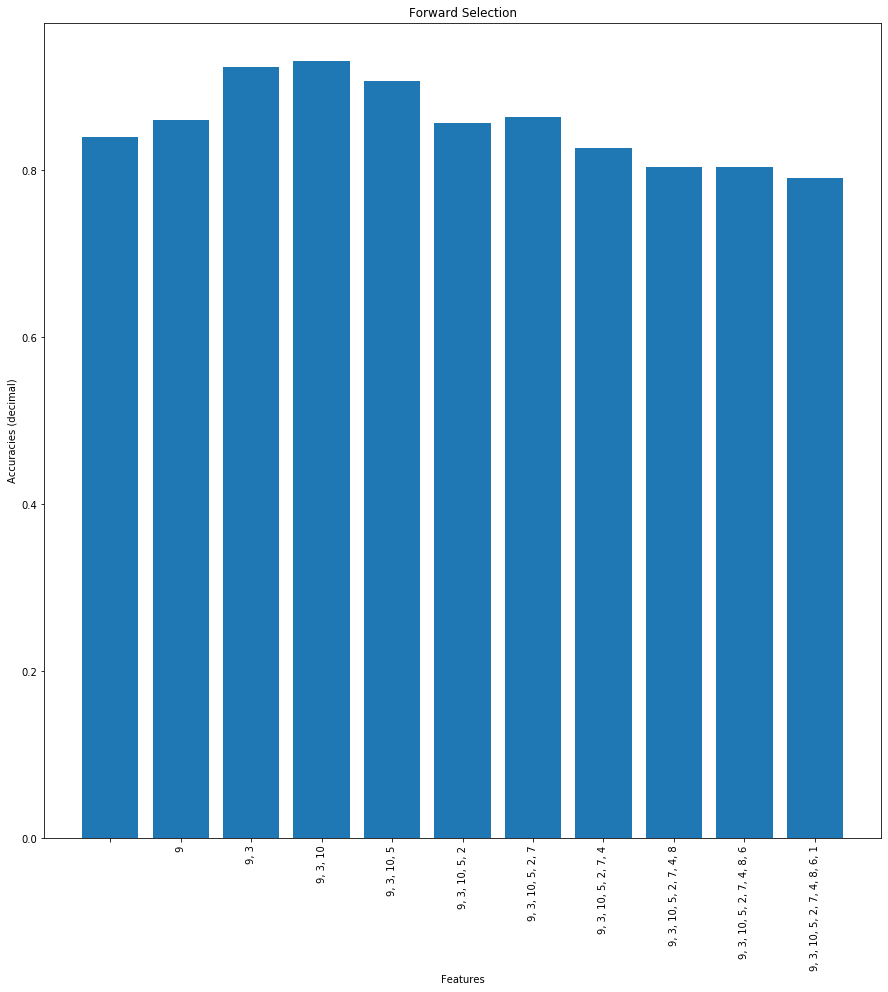

In [12]:
forwardGraph(resForward, forwardAccuracies)

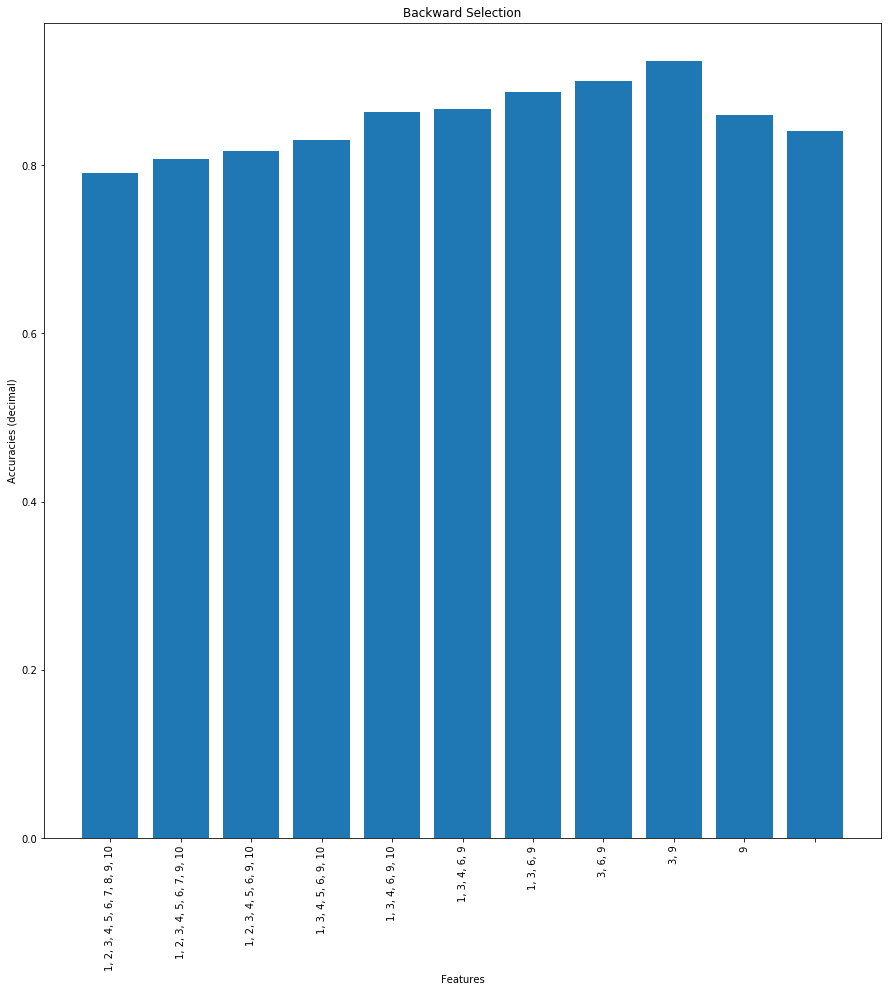

In [13]:
backwardGraph(resBackward, backwardAccuracies)